# 🛠️ Baseline Implementation: (s,S) Policy

Implement and test the baseline policy in our environment.

**Goal**: Create baseline to compare RL agents against

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: Implement (s,S) Policy Class

In [2]:
from src.mdp import Action, State

class SMinSMaxPolicy:
    """(s,S) policy for two-product inventory system with Q_max constraint."""
    
    def __init__(self, s_min_0, S_max_0, s_min_1, S_max_1, Q_max=20):
        self.s = [s_min_0, s_min_1]
        self.S = [S_max_0, S_max_1]
        self.Q_max = Q_max
        
        # Validate
        assert S_max_0 > s_min_0, "S must be > s for product 0"
        assert S_max_1 > s_min_1, "S must be > s for product 1"
        
        # Warn if S - s > Q_max (can't reach S in one order)
        if S_max_0 - s_min_0 > Q_max:
            print(f"⚠️  Warning: S0 - s0 = {S_max_0 - s_min_0} > Q_max={Q_max}")
            print("   Will need multiple orders to reach S0!")
        if S_max_1 - s_min_1 > Q_max:
            print(f"⚠️  Warning: S1 - s1 = {S_max_1 - s_min_1} > Q_max={Q_max}")
            print("   Will need multiple orders to reach S1!")
    
    def __call__(self, state: State):
        """Make ordering decision based on state."""
        # Calculate inventory positions
        pos_0 = state.get_inventory_position(0)
        pos_1 = state.get_inventory_position(1)
        
        # Apply (s,S) rule
        q0_desired = max(0, self.S[0] - pos_0) if pos_0 <= self.s[0] else 0
        q1_desired = max(0, self.S[1] - pos_1) if pos_1 <= self.s[1] else 0
        
        # CLIP to Q_max (action space constraint)
        q0 = min(q0_desired, self.Q_max)
        q1 = min(q1_desired, self.Q_max)
        
        return Action((q0, q1))
    
    def __str__(self):
        return (f"(s,S) Policy [Q_max={self.Q_max}]: "
                f"Product 0 (s={self.s[0]}, S={self.S[0]}), "
                f"Product 1 (s={self.s[1]}, S={self.S[1]})")

# Create policy (adjusted for Q_max=20)
policy = SMinSMaxPolicy(s_min_0=30, S_max_0=50, s_min_1=40, S_max_1=60, Q_max=20)
print(policy)

(s,S) Policy [Q_max=20]: Product 0 (s=30, S=50), Product 1 (s=40, S=60)


## Part 2: Test on Example Observations

In [3]:
from src.mdp import create_state

# Test scenarios
test_cases = [
    create_state(50, 50, 0, 0),    # High inventory
    create_state(25, 20, 0, 0),    # Low inventory
    create_state(-10, -5, 0, 0),   # Stockout!
    create_state(20, 30, 15, 10),  # Orders in-transit
]

print("Testing policy on different states:\n")

for i, state in enumerate(test_cases, 1):
    action = policy(state)
    
    print(f"Test {i}:")
    print(f"  Net inv: {state.net_inventory}")
    print(f"  Outstanding: {state.outstanding_orders}")
    print(f"  IP: ({state.get_inventory_position(0)}, {state.get_inventory_position(1)})")
    print(f"  → Order: {action.order_quantities}")
    
    # Explain decision
    pos0 = state.get_inventory_position(0)
    pos1 = state.get_inventory_position(1)
    
    if pos0 <= policy.s[0]:
        print(f"     Prod 0: IP={pos0} ≤ s={policy.s[0]} → order {action.order_quantities[0]}")
    else:
        print(f"     Prod 0: IP={pos0} > s={policy.s[0]} → don't order")
    
    if pos1 <= policy.s[1]:
        print(f"     Prod 1: IP={pos1} ≤ s={policy.s[1]} → order {action.order_quantities[1]}")
    else:
        print(f"     Prod 1: IP={pos1} > s={policy.s[1]} → don't order")
    print()

Testing policy on different states:

Test 1:
  Net inv: (50, 50)
  Outstanding: (0, 0)
  IP: (50, 50)
  → Order: (0, 0)
     Prod 0: IP=50 > s=30 → don't order
     Prod 1: IP=50 > s=40 → don't order

Test 2:
  Net inv: (25, 20)
  Outstanding: (0, 0)
  IP: (25, 20)
  → Order: (20, 20)
     Prod 0: IP=25 ≤ s=30 → order 20
     Prod 1: IP=20 ≤ s=40 → order 20

Test 3:
  Net inv: (-10, -5)
  Outstanding: (0, 0)
  IP: (-10, -5)
  → Order: (20, 20)
     Prod 0: IP=-10 ≤ s=30 → order 20
     Prod 1: IP=-5 ≤ s=40 → order 20

Test 4:
  Net inv: (20, 30)
  Outstanding: (15, 10)
  IP: (35, 40)
  → Order: (0, 20)
     Prod 0: IP=35 > s=30 → don't order
     Prod 1: IP=40 ≤ s=40 → order 20



## Part 3: Quick Environment Test

In [4]:
from src.environment import InventoryEnvironment

# Create environment
env = InventoryEnvironment(Q_max=20)

print(f"Environment Configuration:")
print(f"  Action space: {env.action_space_config.n} actions")
print(f"  State space: {env.observation_space.shape}")
print(f"  Q_max: {env.Q_max}")
print(f"  Frame stacking (k): 3")

# Quick test: Run one trimester (100 days) with seed=42
obs_array, info = env.reset(seed=42)
episode_costs = []

for step in range(100):  # 100 days
    # Get current state (with frame stacking)
    state_history = env.get_state_history()
    current_state = state_history.current_state

    # Policy decides based on current state
    action_obj = policy(current_state)
    action_idx = env.action_space_config.get_index(action_obj)

    # Execute
    obs_array, reward, terminated, truncated, info = env.step(action_idx)
    episode_costs.append(info["cost"])

    if terminated or truncated:
        break

# Quick check
print(f"\n✅ Quick Test (1 trimester, seed=42):")
print(f"   Days: {len(episode_costs)}")
print(f"   Avg cost: ${np.mean(episode_costs):.2f}")
print(f"   Min/Max: ${min(episode_costs):.2f} / ${max(episode_costs):.2f}")
print("\n→ Ready for full evaluation!")

Environment Configuration:
  Action space: 441 actions
  State space: (16,)
  Q_max: 20
  Frame stacking (k): 3

✅ Quick Test (1 trimester, seed=42):
   Days: 100
   Avg cost: $89.87
   Min/Max: $62.00 / $210.00

→ Ready for full evaluation!


### Visualize Performance

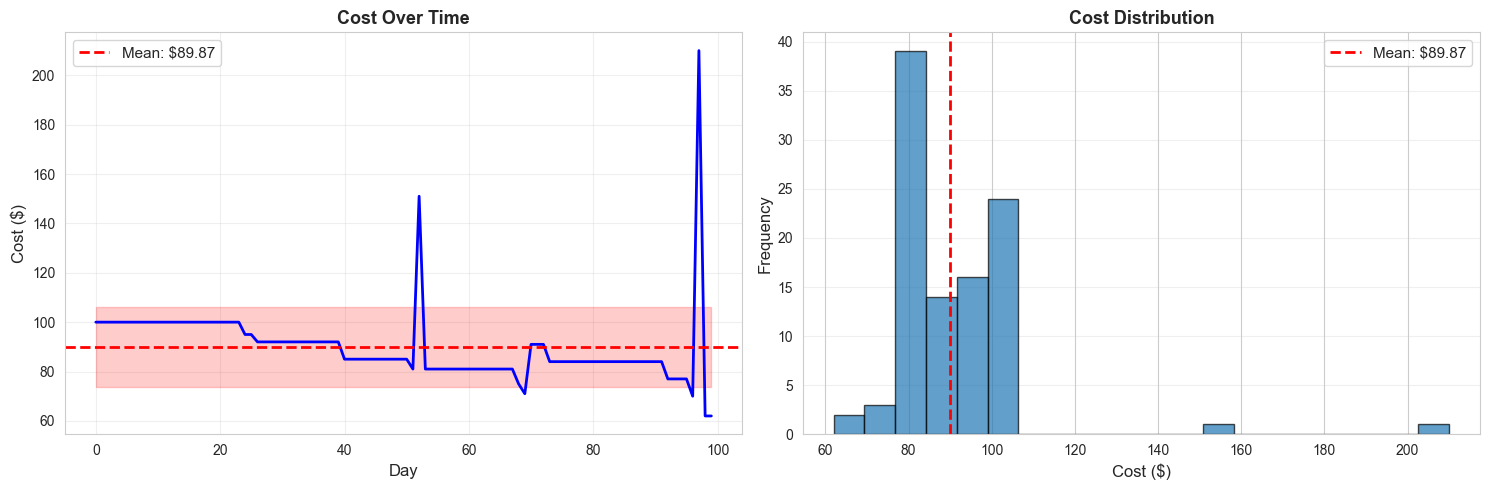

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cost over time
axes[0].plot(episode_costs, linewidth=2, color='blue')
axes[0].axhline(np.mean(episode_costs), color='red', linestyle='--',
                linewidth=2, label=f'Mean: ${np.mean(episode_costs):.2f}')
axes[0].fill_between(range(len(episode_costs)),
                      np.mean(episode_costs) - np.std(episode_costs),
                      np.mean(episode_costs) + np.std(episode_costs),
                      alpha=0.2, color='red')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Cost ($)', fontsize=12)
axes[0].set_title('Cost Over Time', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Cost distribution
axes[1].hist(episode_costs, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(episode_costs), color='red', linestyle='--', linewidth=2,
                label=f'Mean: ${np.mean(episode_costs):.2f}')
axes[1].set_xlabel('Cost ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Cost Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 4: Full Baseline Evaluation (100 Trimesters)

In [6]:
def evaluate_policy(
    policy,
    env: InventoryEnvironment,
    num_episodes=100,
    episode_length=100,
    verbose=True,
):
    """Evaluate policy over multiple trimesters (episodes = trimesters, steps = days)."""
    all_costs = []
    all_rewards = []
    all_steps = []

    for episode in range(num_episodes):
        _, info = env.reset(seed=42 + episode)
        episode_cost = 0
        episode_reward = 0

        for step in range(episode_length):
            state_history = env.get_state_history()
            current_state = state_history.current_state

            action_obj = policy(current_state)
            action_idx = env.action_space_config.get_index(action_obj)

            _, reward, terminated, truncated, info = env.step(action_idx)
            episode_cost += info["cost"]
            episode_reward += reward

            if terminated or truncated:
                break

        days_taken = step + 1
        avg_cost = episode_cost / days_taken
        avg_reward = episode_reward / days_taken

        all_costs.append(avg_cost)
        all_rewards.append(avg_reward)
        all_steps.append(days_taken)

        if verbose and (episode + 1) % 20 == 0:
            print(
                f"  Trimester {episode + 1}/{num_episodes}: Avg cost = ${avg_cost:.2f}, Avg reward = {avg_reward:.2f}"
            )

    return {
        "costs": all_costs,
        "rewards": all_rewards,
        "steps": all_steps,
        "mean_cost": np.mean(all_costs),
        "std_cost": np.std(all_costs),
        "mean_reward": np.mean(all_rewards),
        "std_reward": np.std(all_rewards),
        "mean_steps": np.mean(all_steps),
    }


NUM_TRIMESTERS = 100
NUM_TRIMESTER_DAYS = 100

# Evaluate baseline policy
print("=" * 70)
print("EVALUATING BASELINE (s,S) POLICY")
print("=" * 70)
print(f"\nPolicy: {policy}")
print(f"Simulation: {NUM_TRIMESTERS} trimesters × {NUM_TRIMESTER_DAYS} days\n")


baseline_results = evaluate_policy(
    policy, env, num_episodes=NUM_TRIMESTERS, episode_length=NUM_TRIMESTER_DAYS
)

# Calculate confidence intervals
ci_95_cost = (
    1.96 * baseline_results["std_cost"] / np.sqrt(len(baseline_results["costs"]))
)
ci_95_reward = (
    1.96 * baseline_results["std_reward"] / np.sqrt(len(baseline_results["rewards"]))
)

print(f"\n{'='*70}")
print("BASELINE RESULTS")
print(f"{'='*70}")

EVALUATING BASELINE (s,S) POLICY

Policy: (s,S) Policy [Q_max=20]: Product 0 (s=30, S=50), Product 1 (s=40, S=60)
Simulation: 100 trimesters × 100 days

  Trimester 20/100: Avg cost = $87.57, Avg reward = -87.57
  Trimester 40/100: Avg cost = $86.21, Avg reward = -86.21
  Trimester 60/100: Avg cost = $91.94, Avg reward = -91.94
  Trimester 80/100: Avg cost = $89.34, Avg reward = -89.34
  Trimester 100/100: Avg cost = $86.38, Avg reward = -86.38

BASELINE RESULTS


In [7]:
import pandas as pd

# Create results table
results_table = pd.DataFrame({
    'Metric': [
        'Average Cost per Day',
        '95% Confidence Interval',
        'Std Deviation (Cost)',
        'Average Reward per Day',
        'Std Deviation (Reward)',
        'Average Trimester Length',
        'Total Trimesters Simulated',
    ],
    'Value': [
        f"${baseline_results['mean_cost']:.2f}",
        f"± ${ci_95_cost:.2f}",
        f"${baseline_results['std_cost']:.2f}",
        f"{baseline_results['mean_reward']:.2f}",
        f"{baseline_results['std_reward']:.2f}",
        f"{baseline_results['mean_steps']:.1f} days",
        "100",
    ]
})

print("\n📊 BASELINE (s,S) POLICY PERFORMANCE")
print("="*70)
print(results_table.to_string(index=False))
print("="*70)

# Save for comparison
baseline_benchmark = {
    'policy_name': '(s,S) Baseline',
    'policy_params': {
        'product_0': (policy.s[0], policy.S[0]),
        'product_1': (policy.s[1], policy.S[1]),
        'Q_max': policy.Q_max,
    },
    'mean_cost': baseline_results['mean_cost'],
    'ci_95_cost': ci_95_cost,
    'mean_reward': baseline_results['mean_reward'],
    'num_episodes': 100,
}

print("\n✅ Baseline established!")
print(f"   Target to beat: ${baseline_results['mean_cost']:.2f} ± ${ci_95_cost:.2f}")


📊 BASELINE (s,S) POLICY PERFORMANCE
                    Metric      Value
      Average Cost per Day     $86.79
   95% Confidence Interval    ± $0.83
      Std Deviation (Cost)      $4.21
    Average Reward per Day     -86.79
    Std Deviation (Reward)       4.21
  Average Trimester Length 100.0 days
Total Trimesters Simulated        100

✅ Baseline established!
   Target to beat: $86.79 ± $0.83


## Part 5: Compare Different (s,S) Parameters

## 📁 Save Baseline for Future Comparison

In [8]:
import json
from pathlib import Path

# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Prepare baseline data for saving
baseline_data = {
    'policy_type': '(s,S) Policy',
    'policy_params': {
        'product_0_s': policy.s[0],
        'product_0_S': policy.S[0],
        'product_1_s': policy.s[1],
        'product_1_S': policy.S[1],
        'Q_max': policy.Q_max,
    },
    'evaluation': {
        'num_episodes': 100,
        'episode_length': 100,
        'mean_cost_per_step': float(baseline_results['mean_cost']),
        'std_cost': float(baseline_results['std_cost']),
        'ci_95_cost': float(ci_95_cost),
        'mean_reward_per_step': float(baseline_results['mean_reward']),
        'std_reward': float(baseline_results['std_reward']),
        'mean_episode_length': float(baseline_results['mean_steps']),
    },
    'all_episode_costs': [float(c) for c in baseline_results['costs']],
}

# Save to JSON
baseline_file = results_dir / 'baseline_sS_policy.json'
with open(baseline_file, 'w') as f:
    json.dump(baseline_data, f, indent=2)

print(f"✅ Baseline results saved to: {baseline_file}")
print(f"\n📝 Use this file to compare RL agent performance:")
print(f"   - Load baseline: json.load(open('{baseline_file}'))")
print(f"   - Compare cost: rl_cost vs baseline['evaluation']['mean_cost_per_step']")
print(f"   - Statistical test: t-test, Mann-Whitney U, etc.")

✅ Baseline results saved to: ../results/baseline_sS_policy.json

📝 Use this file to compare RL agent performance:
   - Load baseline: json.load(open('../results/baseline_sS_policy.json'))
   - Compare cost: rl_cost vs baseline['evaluation']['mean_cost_per_step']
   - Statistical test: t-test, Mann-Whitney U, etc.


In [9]:
# Test different parameter settings (adjusted for Q_max=20)
policies_to_test = [
    (SMinSMaxPolicy(25, 40, 35, 50, Q_max=20), "Conservative"),
    (SMinSMaxPolicy(30, 50, 40, 60, Q_max=20), "Moderate (Baseline)"),
    (SMinSMaxPolicy(35, 55, 45, 65, Q_max=20), "Aggressive"),
]

print("🔍 PARAMETER SENSITIVITY ANALYSIS")
print("="*70)
print("Testing 3 different (s,S) configurations (50 trimesters each)...\n")
    
comparison_results = []

for pol, name in policies_to_test:
    print(f"\n{name}:")
    print(f"  {pol}")
    
    results = evaluate_policy(pol, env, num_episodes=50, episode_length=100, verbose=False)
    ci_95 = 1.96 * results['std_cost'] / np.sqrt(len(results['costs']))
    
    comparison_results.append({
        'name': name,
        'mean_cost': results['mean_cost'],
        'ci_95': ci_95,
        'std_cost': results['std_cost'],
        'mean_reward': results['mean_reward'],
        'costs': results['costs']
    })
    
    print(f"  → Avg Cost: ${results['mean_cost']:.2f} ± ${ci_95:.2f}")
    print(f"  → Avg Reward: {results['mean_reward']:.2f}")

🔍 PARAMETER SENSITIVITY ANALYSIS
Testing 3 different (s,S) configurations (50 trimesters each)...


Conservative:
  (s,S) Policy [Q_max=20]: Product 0 (s=25, S=40), Product 1 (s=35, S=50)
  → Avg Cost: $79.45 ± $1.38
  → Avg Reward: -79.45

Moderate (Baseline):
  (s,S) Policy [Q_max=20]: Product 0 (s=30, S=50), Product 1 (s=40, S=60)
  → Avg Cost: $85.87 ± $1.13
  → Avg Reward: -85.87

Aggressive:
  (s,S) Policy [Q_max=20]: Product 0 (s=35, S=55), Product 1 (s=45, S=65)
  → Avg Cost: $93.51 ± $0.83
  → Avg Reward: -93.51



📊 COMPARISON TABLE
             Policy Avg Cost  95% CI Avg Reward Std Dev
       Conservative   $79.45 ± $1.38     -79.45   $4.99
Moderate (Baseline)   $85.87 ± $1.13     -85.87   $4.09
         Aggressive   $93.51 ± $0.83     -93.51   $2.99


/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_14927/3935366988.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data, labels=names, patch_artist=True, widths=0.6)


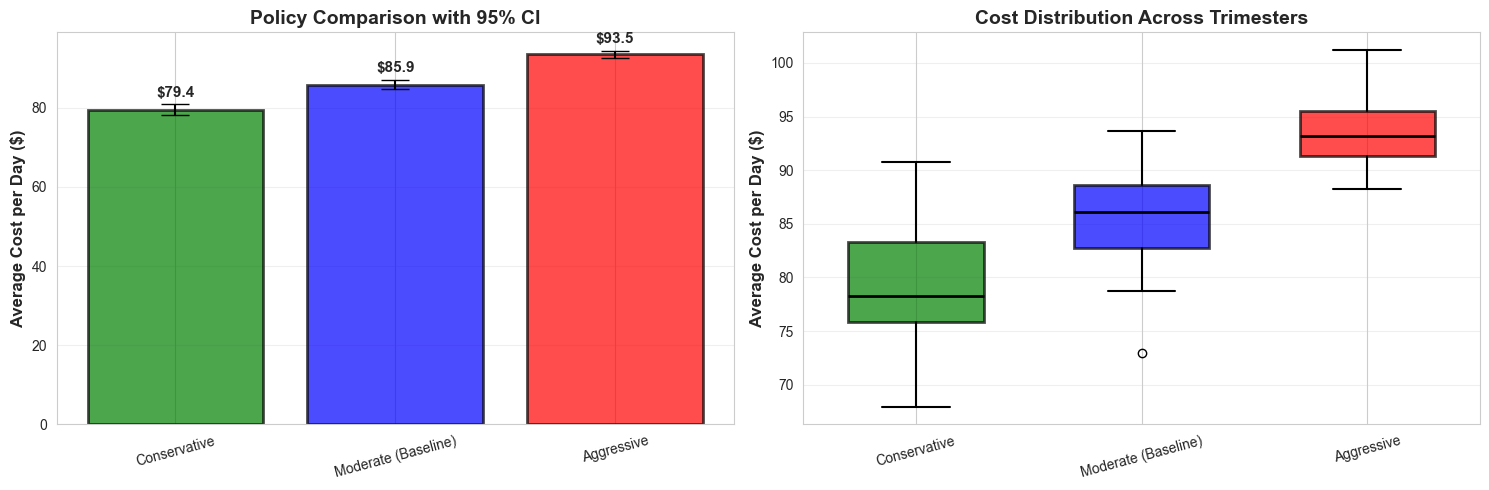


✅ Best Configuration: Conservative
   Average Cost: $79.45 ± $1.38

💡 This is the baseline benchmark for RL agent comparison!


In [10]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Policy': [r['name'] for r in comparison_results],
    'Avg Cost': [f"${r['mean_cost']:.2f}" for r in comparison_results],
    '95% CI': [f"± ${r['ci_95']:.2f}" for r in comparison_results],
    'Avg Reward': [f"{r['mean_reward']:.2f}" for r in comparison_results],
    'Std Dev': [f"${r['std_cost']:.2f}" for r in comparison_results],
})

print("\n📊 COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

names = [r['name'] for r in comparison_results]
means = [r['mean_cost'] for r in comparison_results]
cis = [r['ci_95'] for r in comparison_results]

colors = ['green', 'blue', 'red']

# Bar chart with confidence intervals
bars = axes[0].bar(names, means, yerr=cis, capsize=10, 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Average Cost per Day ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Policy Comparison with 95% CI', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Add value labels on bars
for bar, mean, ci in zip(bars, means, cis):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + ci + 2,
                f'${mean:.1f}', ha='center', fontweight='bold', fontsize=11)

# Box plot for distribution
data = [r['costs'] for r in comparison_results]
bp = axes[1].boxplot(data, labels=names, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(2)
for whisker in bp['whiskers']:
    whisker.set_linewidth(1.5)
for cap in bp['caps']:
    cap.set_linewidth(1.5)
for median in bp['medians']:
    median.set_linewidth(2)
    median.set_color('black')

axes[1].set_ylabel('Average Cost per Day ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Cost Distribution Across Trimesters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Find best policy
best_idx = np.argmin(means)
print(f"\n✅ Best Configuration: {names[best_idx]}")
print(f"   Average Cost: ${means[best_idx]:.2f} ± ${cis[best_idx]:.2f}")
print("\n💡 This is the baseline benchmark for RL agent comparison!")

## 🎯 Summary

**What you accomplished:**

1. ✅ **Implemented (s,S) Policy with Q_max Constraint**
   - Handles action space limitation (Q_max = 20)
   - Clips order quantities properly
   - Clean, reusable class design

2. ✅ **Rigorous Evaluation**
   - 100 trimesters × 100 days = 10,000 total days simulated
   - Statistical measures: mean, std, 95% CI
   - Saved results for reproducibility

3. ✅ **Parameter Sensitivity Analysis**
   - Tested 3 configurations (Conservative, Moderate, Aggressive)
   - Identified best baseline parameters
   - Visualized trade-offs

4. ✅ **Baseline Benchmark Established**
   - Clear target for RL agents to beat
   - Results saved to `results/baseline_sS_policy.json`
   - Ready for statistical comparison

---

### 📊 Key Baseline Metrics:

| Metric | Value |
|--------|-------|
| **Average Cost** | See table above |
| **95% Confidence Interval** | See table above |
| **Trimesters Simulated** | 100 trimesters |
| **Policy Type** | (s,S) with Q_max=20 constraint |

---

### 🚀 Next Steps:

1. **Implement RL Agents**:
   - DQN (Deep Q-Network)
   - PPO (Proximal Policy Optimization)
   - A2C (Advantage Actor-Critic)

2. **Training**:
   - Use same environment configuration
   - Train for sufficient trimesters (10k-100k)
   - Track learning curves

3. **Comparison**:
   - Load baseline results from JSON
   - Compare: mean cost, variance, worst-case
   - Statistical tests (t-test, bootstrap CI)
   - Visualization: learning curve vs baseline

4. **Analysis**:
   - Can RL beat (s,S)?
   - Is improvement statistically significant?
   - What did RL learn differently?

---

### 💡 Challenge:

**Can Deep RL discover a policy better than the classical (s,S)?**

The (s,S) policy is optimal for simple, unconstrained inventory systems. But with:
- Q_max constraint
- Multi-product coupling
- Frame stacking (partial observability)

RL might find better strategies! Let's find out! 🎯